<div style="background-color:#a4d7e1;padding:25px;">
    <p style="font-size:25px;font-weight:bold; text-align:center;color:#293462">Pose Estimation (Localization)</p>
    <div style="width:130px; height:auto;position:relative;margin:20px auto 20px auto;"><a href="http://kwin.ir" style="font-weight:bold; margin-left:4px;">By Saeed Khosravi</a></div>
    <img src="imgs/img.png">
</div>

<div style="background-color:#a4d7e1;padding:25px;"> 
 <p>Pose Estimation is a way to determine parts of human body in different positions. Localizing  14 points with separate x and y was the aim of this project.</p>
    <p>In this project I exploit of Fully Convolutional Networks ( <a href="https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf">Jonathan Long, Evan Shelhamer, Trevor Darrell; The IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2015, pp. 3431-3440</a> ) to train the model</p>
</div>

In [1]:
# Libraries
import numpy as np # linear algebra module
import scipy.io # work with .mat file
import os, glob # work with directories and files in the operating system
import matplotlib.pyplot as plt # plot images and joint points

# torch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules import Module
from torch.autograd import Variable
# torchvision modules
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from utils import *

batch_size = 8 # every time it loads up batch_size images to the RAM

<div style="background-color:#a4d7e1;padding:25px;">
    <p style="font-weight:bold; font-size:17px;">1. Loading <a href="http://sam.johnson.io/research/lsp.html" style="font-weight:bold; font-size:17px;">LSP Dataset</a></p>
    <li style="margin:10px 0px 0px 20px;">There are 14 joint points consist of:</li>
    <img src="imgs/img1.png">
</div>

In [2]:
DATA_DIR = DATA_DIR = 'dataset/lsp_dataset_original/'
os.listdir(f'{DATA_DIR}')

['.DS_Store', 'joints.mat', 'images', 'README.txt']

In [3]:
trn_im_files = sorted(glob.glob(f'{DATA_DIR}images/train/*.*')) # load train images and sort it by their names
vld_im_files = sorted(glob.glob(f'{DATA_DIR}images/valid/*.*')) # load train images and sort it by their names
tst_im_files = sorted(glob.glob(f'{DATA_DIR}images/test/*.*')) # load train images and sort it by their names
print("train images are", len(trn_im_files)) # I remove 4 images from 1500 training images to be devidable to 8
print("valid images are", len(vld_im_files))
print("test images are", len(tst_im_files))

train images are 1496
valid images are 200
test images are 300


In [4]:
jnts_file = scipy.io.loadmat('dataset/lsp_dataset_original/joints.mat') # loading labels or joint locations
print(jnts_file.keys())
joints = np.array(jnts_file['joints']) # converting to numpy array
trn_joints = joints[:,:,0:1496] # split train images
vld_joints = joints[:,:,1500:1700] 
tst_joints = joints[:,:,1700:2000]

dict_keys(['__header__', '__version__', '__globals__', 'joints'])


<div style="background-color:#a4d7e1;padding:25px;">
    <p><b>lsb_dataset</b> is a class that I wrote to return items depending on the number of joints and the related image</p>
    <p> In some problems there are more than one image related to each sample that needs to be return as a sample so we need to make a class to do this. For example in Face Recognition we have 3 images as a sample: Anchor Image, Negative Image and Positive Image</p>
</div>

In [5]:
train_ds = lsb_dataset(trn_im_files, trn_joints)
valid_ds = lsb_dataset(vld_im_files, vld_joints)
test_ds = lsb_dataset(tst_im_files, tst_joints)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


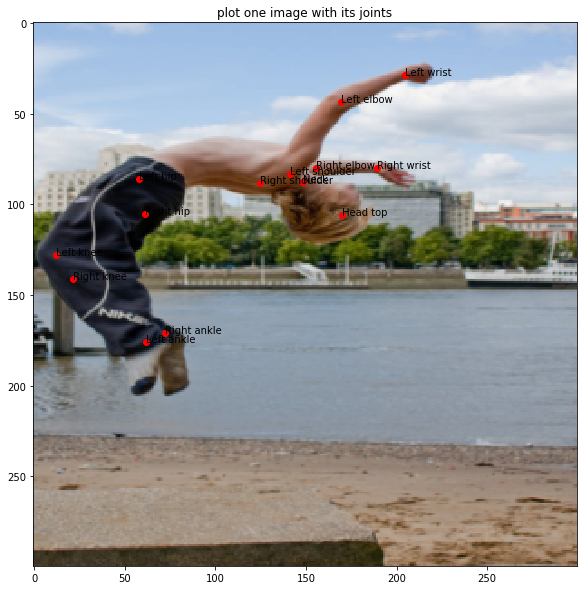

In [6]:
image, jnt_loc = train_ds[100]
show_im_jnts(image, jnt_loc,"plot one image with its joints") # to make sure everything goes well

In [7]:
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True) #making torch data loaders to work with torch
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle=True)

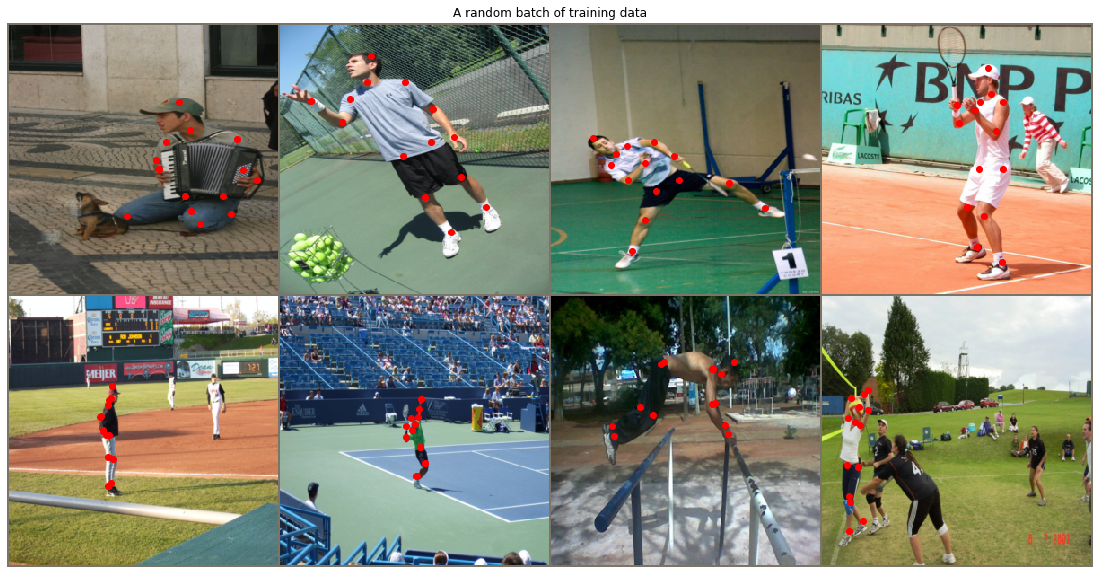

In [8]:
# ploting a batch of images to make sure everything works fine
dataiter = iter(test_dl)
imgs, jnt_locs = next(dataiter)
img = torchvision.utils.make_grid(imgs, nrow=4)
imshow(img, jnt_locs, title='A random batch of training data')

<div style="background-color:#a4d7e1;padding:25px;">
    <p style="font-weight:bold; font-size:17px;">2. Making a Fully Convolutional Network (FCN)</a></p>
    <li style="margin:10px 0px 0px 20px;">I use a pre-trained resnet CNN to make a FCN network as following:</li>
    <li style="margin:10px 0px 0px 40px;">Remove the last fully connected layer of resnet network</li>
    <li style="margin:10px 0px 0px 40px;">Adding a linear layer which gets the outputs of the last convolutional layer and output 28 numbers[utils.py]</li>
</div>

In [9]:
fcn = my_FCN()
criterion = my_LLoss()
optimizer = optim.Adam(fcn.parameters(), lr=0.0001) # I use Adam stochastic optimization which can be replaced by other stochastic algorithms
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95) # changes learning rate based on different epochs

/Users/kwin/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [23]:
fcn = train_model(fcn, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=3)

Epoch 1/3
----------
Batch 0 of 187 loss : 3.9301023483276367
Batch 1 of 187 loss : 3.057776689529419
Batch 2 of 187 loss : 4.231743335723877
Batch 3 of 187 loss : 2.9109935760498047
Batch 4 of 187 loss : 3.525665760040283
Batch 5 of 187 loss : 1.6715381145477295
Batch 6 of 187 loss : 4.145299434661865
Batch 7 of 187 loss : 3.481583595275879
Batch 8 of 187 loss : 6.748783111572266
Batch 9 of 187 loss : 2.99690842628479
Batch 10 of 187 loss : 1.7512928247451782
Batch 11 of 187 loss : 1.8930448293685913
Batch 12 of 187 loss : 3.3929977416992188
Batch 13 of 187 loss : 2.4740540981292725
Batch 14 of 187 loss : 8.518693923950195
Batch 15 of 187 loss : 2.3811235427856445
Batch 16 of 187 loss : 3.6447219848632812
Batch 17 of 187 loss : 4.462516784667969
Batch 18 of 187 loss : 2.09743070602417
Batch 19 of 187 loss : 8.17574691772461
Batch 20 of 187 loss : 2.0214180946350098
Batch 21 of 187 loss : 2.4759724140167236
Batch 22 of 187 loss : 3.5165655612945557
Batch 23 of 187 loss : 2.480629444122

Batch 9 of 187 loss : 7.199248313903809
Batch 10 of 187 loss : 3.495936155319214
Batch 11 of 187 loss : 4.184895038604736
Batch 12 of 187 loss : 3.203646659851074
Batch 13 of 187 loss : 5.624758720397949
Batch 14 of 187 loss : 2.9418182373046875
Batch 15 of 187 loss : 2.44903302192688
Batch 16 of 187 loss : 3.584199905395508
Batch 17 of 187 loss : 3.3478496074676514
Batch 18 of 187 loss : 2.576645851135254
Batch 19 of 187 loss : 5.991094589233398
Batch 20 of 187 loss : 5.302716255187988
Batch 21 of 187 loss : 9.135473251342773
Batch 22 of 187 loss : 3.755430221557617
Batch 23 of 187 loss : 5.724292278289795
Batch 24 of 187 loss : 4.192111968994141
Batch 25 of 187 loss : 2.928590774536133
Batch 26 of 187 loss : 5.125622749328613
Batch 27 of 187 loss : 2.2779781818389893
Batch 28 of 187 loss : 2.3180720806121826
Batch 29 of 187 loss : 2.966001272201538
Batch 30 of 187 loss : 4.299727439880371
Batch 31 of 187 loss : 4.811514377593994
Batch 32 of 187 loss : 2.237326145172119
Batch 33 of 18

Batch 18 of 187 loss : 3.241644859313965
Batch 19 of 187 loss : 1.9283055067062378
Batch 20 of 187 loss : 1.9708707332611084
Batch 21 of 187 loss : 3.5018014907836914
Batch 22 of 187 loss : 6.065433025360107
Batch 23 of 187 loss : 4.910491943359375
Batch 24 of 187 loss : 1.4968464374542236
Batch 25 of 187 loss : 3.457644462585449
Batch 26 of 187 loss : 1.5568726062774658
Batch 27 of 187 loss : 2.8171298503875732
Batch 28 of 187 loss : 2.398707866668701
Batch 29 of 187 loss : 6.295877456665039
Batch 30 of 187 loss : 3.4139392375946045
Batch 31 of 187 loss : 3.186361789703369
Batch 32 of 187 loss : 2.1259305477142334
Batch 33 of 187 loss : 2.6842572689056396
Batch 34 of 187 loss : 4.7504682540893555
Batch 35 of 187 loss : 2.585050582885742
Batch 36 of 187 loss : 3.1032004356384277
Batch 37 of 187 loss : 1.669927954673767
Batch 38 of 187 loss : 3.287693500518799
Batch 39 of 187 loss : 2.210186004638672
Batch 40 of 187 loss : 3.271975517272949
Batch 41 of 187 loss : 4.2215752601623535
Batc

In [13]:
torch.save(fcn, 'trained_fcn.pt')

In [14]:
fcn = torch.load('trained_fcn.pt')

In [149]:
dataiter = iter(valid_dl)
imgs, jnt_locs = next(dataiter)
coords = fcn(imgs)
print(type(imgs))

<class 'torch.Tensor'>


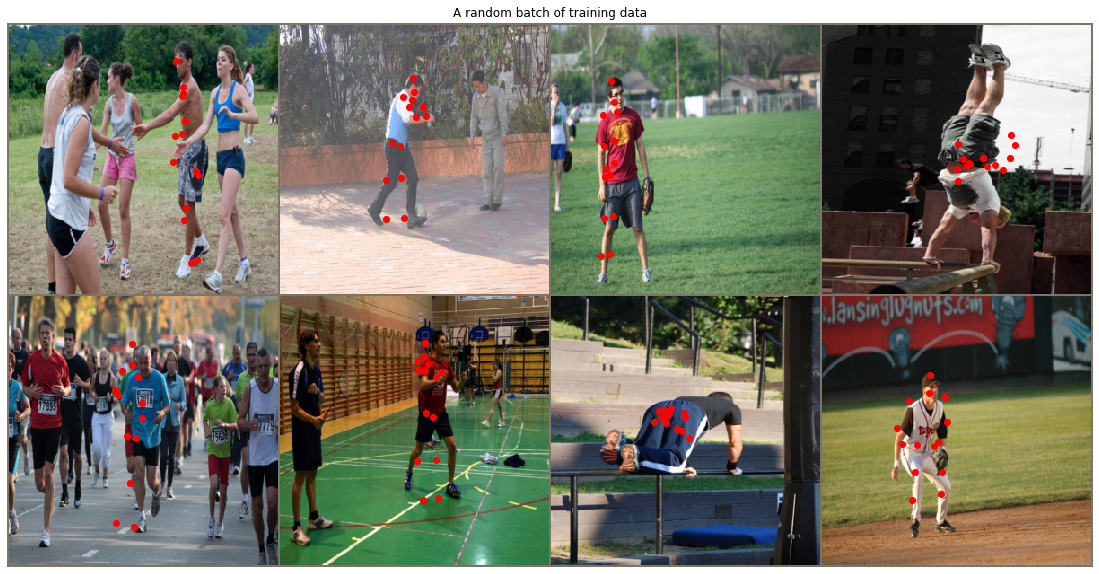

In [142]:
img = torchvision.utils.make_grid(imgs, nrow=4)
coords = coords.reshape((8,28,1))
coords = coords.detach().numpy()
imshow(img, coords, title='A random batch of training data')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


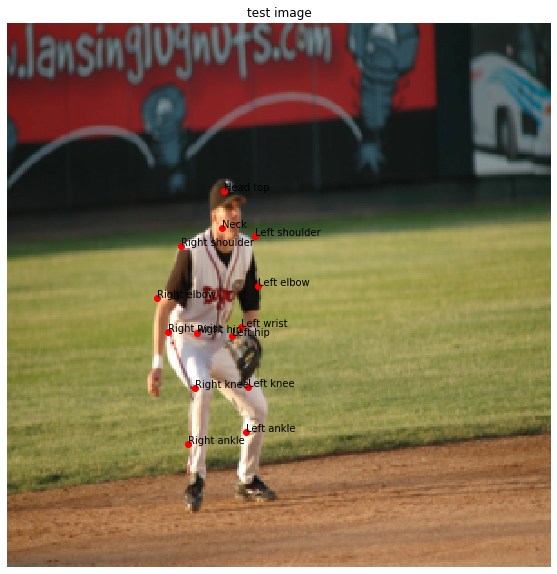

In [146]:
img = imgs[7]
coord = coords[7,:,:]
imshow_one(img, coord, 'test image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


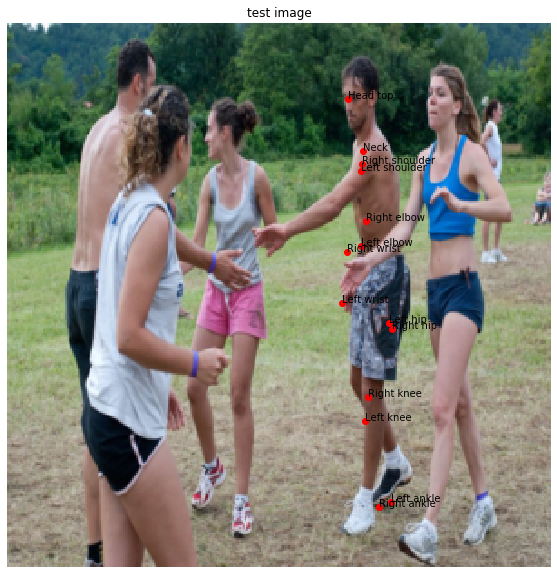

In [148]:
img = imgs[0]
coord = coords[0,:,:]
imshow_one(img, coord, 'test image')